In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
# Append src directory to path
import sys
sys.path.append('C:\\Users\\kingt\\Dropbox\\Programming\\NeuralSimV3\\NeuroSimV3\\python\\src')

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from neuron_population import NeuronPopulation
from connectome import Connectome
from overhead import Simulation
import networkx as nx
from networkx.algorithms import smallworld
import random
from collections import Counter
from scipy.spatial import cKDTree
from neuron_templates import neuron_type_IZ
from network_grower import *

ModuleNotFoundError: No module named 'neuron_population'

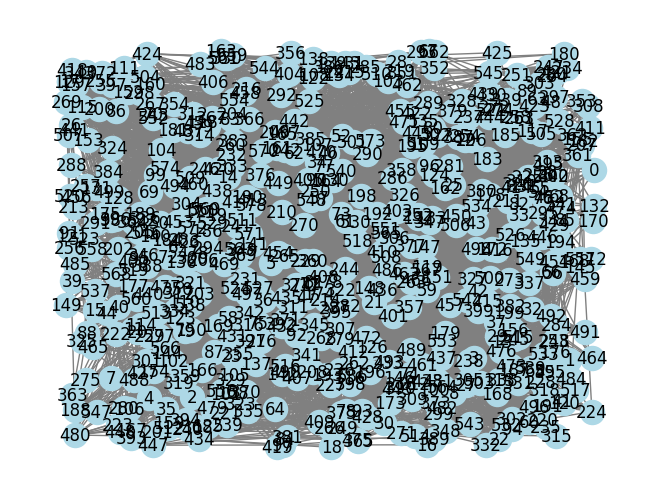

In [5]:
g = nx.geometric_soft_configuration_graph(beta=1.4, n=575, gamma=2.7, mean_degree=21.8)

# Prune unconnected nodes
g.remove_nodes_from(list(nx.isolates(g)))

# Visualize the pruned graph
pos = nx.random_layout(g, dim=2)
nx.draw(g, pos, with_labels=True, node_color='lightblue', edge_color='gray')
plt.show()

In [6]:
# Find clustering coefficient and average shortest path length
clustering_coeff = nx.average_clustering(g)
avg_shortest_path_length = nx.average_shortest_path_length(g)
print(f"Clustering Coefficient: {clustering_coeff}")
print(f"Average Shortest Path Length: {avg_shortest_path_length}")
# Beweenness, closeness, eigenvector centrality
betweenness = nx.betweenness_centrality(g)
closeness = nx.closeness_centrality(g)
eigenvector = nx.eigenvector_centrality(g)
# Print mean of each centrality measure
print(f"Mean Betweenness Centrality: {np.mean(list(betweenness.values()))}")
print(f"Mean Eigenvector Centrality: {np.mean(list(eigenvector.values()))}")
print(f"Mean Closeness Centrality: {np.mean(list(closeness.values()))}")

Clustering Coefficient: 0.2648840470082675
Average Shortest Path Length: 2.6229116800484773
Mean Betweenness Centrality: 0.0028323065969432415
Mean Eigenvector Centrality: 0.031506196233452056
Mean Closeness Centrality: 0.3842400971504448


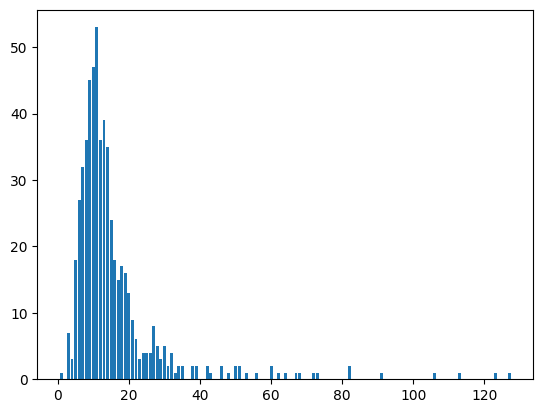

In [7]:
# Degree distribution hist
degree_sequence = sorted([d for n, d in g.degree()], reverse=True)
degree_count = Counter(degree_sequence)
deg, cnt = zip(*degree_count.items())
plt.bar(deg, cnt)
plt.show()

## Generative model 1

In [8]:
def geometric_preferential_attachment(
    N: int,
    m: int = 3,
    dim: int = 2,
    degree_exponent: float = 1.0,
    distance_scale: float = 0.1,
    distance_exponent: float = 1.0,
    initial_attract: float = 1.0,
    directed: bool = False,
    target_on: str = "in",     # "in" or "total" (for directed graphs only)
    periodic: bool = False,    # if True, use torus metric on [0,1]^dim
    seed: int | None = None,
):
    """
    Build a geometric preferential attachment (GPA) graph.

    Parameters
    ----------
    N : int
        Number of nodes.
    m : int
        Edges each new node adds on arrival (≥1). For directed=True,
        these are out-edges from the new node to old nodes.
    dim : int
        Spatial dimension (2 or 3 are common).
    degree_exponent : float
        Preferential-attachment exponent α on degree: attractiveness ∝ (k + k0)^α
        Use α=1.0 for classic PA, α<1 sublinear, α>1 superlinear.
    distance_scale : float
        Length scale λ for geometric penalty. Smaller λ means more local edges.
    distance_exponent : float
        Exponent β on distance penalty: attractiveness ∝ exp(-(d/λ)^β).
    initial_attract : float
        k0, initial attractiveness to avoid zero-probability targets.
    directed : bool
        If True, produce a directed graph with edges from new -> old nodes.
    target_on : {"in","total"}
        For directed graphs, which degree to bias: incoming ("in") or total.
    periodic : bool
        If True, use periodic boundary conditions (torus) for distances.
    seed : int | None
        RNG seed.

    Returns
    -------
    G : nx.Graph or nx.DiGraph
        The generated networkx graph with node attribute 'pos' (np.ndarray of shape (dim,)).
    positions : np.ndarray
        Array of shape (N, dim) with node positions in [0,1]^dim.
    """
    rng = np.random.default_rng(seed)
    if N < m + 1:
        raise ValueError("Need N >= m+1 so early nodes have someone to connect to.")
    if dim < 1:
        raise ValueError("dim must be >=1")

    # Helper: torus (periodic) distance or Euclidean
    def _delta(a, b):
        """a,b: arrays shape (dim,) on [0,1]."""
        if periodic:
            d = np.abs(a - b)
            d = np.minimum(d, 1.0 - d)  # wrap on unit torus
            return np.sqrt((d ** 2).sum())
        else:
            return np.linalg.norm(a - b)

    # Graph + positions
    G = nx.DiGraph() if directed else nx.Graph()
    pos = rng.uniform(0.0, 1.0, size=(N, dim))

    # Seed with a small connected core of m+1 nodes (ring for stability)
    core = m + 1
    G.add_nodes_from(range(core))
    for i in range(core):
        G.nodes[i]["pos"] = pos[i]
    if directed:
        # Make a directed ring both ways for stability (optional; choose one direction if you prefer)
        for i in range(core):
            j = (i + 1) % core
            G.add_edge(i, j)
            G.add_edge(j, i)
    else:
        for i in range(core):
            j = (i + 1) % core
            G.add_edge(i, j)

    # Main growth
    for new in range(core, N):
        G.add_node(new, pos=pos[new])
        # Compute attractiveness of existing targets
        targets = np.arange(new)  # can only connect to older nodes to avoid multiedges among new ones

        # Degrees for bias
        if directed:
            if target_on == "in":
                deg = np.array([G.in_degree(t) for t in targets], dtype=float)
            elif target_on == "total":
                deg = np.array([G.in_degree(t) + G.out_degree(t) for t in targets], dtype=float)
            else:
                raise ValueError("target_on must be 'in' or 'total'")
        else:
            deg = np.array([G.degree(t) for t in targets], dtype=float)

        # Distances from the new node to all previous nodes
        dists = np.linalg.norm(
            np.minimum(np.abs(pos[targets] - pos[new]), 1.0 - np.abs(pos[targets] - pos[new])) if periodic
            else (pos[targets] - pos[new]), axis=1
        )
        # Attractiveness kernel: (deg + k0)^α * exp( - (d/λ)^β )
        geo_term = np.exp(- (dists / max(1e-12, distance_scale)) ** distance_exponent)
        attr = (deg + initial_attract) ** degree_exponent * geo_term

        # If all weights are zero (can happen for extreme params), fall back to uniform
        if not np.isfinite(attr).any() or attr.sum() <= 0:
            probs = np.full_like(attr, 1.0 / attr.size)
        else:
            # Numerical safety
            attr = np.clip(attr, 0, np.finfo(float).max)
            probs = attr / attr.sum()

        # Sample m UNIQUE targets without replacement, biased by probs
        m_eff = min(m, targets.size)  # safety
        chosen = rng.choice(targets, size=m_eff, replace=False, p=probs)

        # Add edges
        if directed:
            for t in chosen:
                if not G.has_edge(new, t):  # avoid accidental duplicates
                    G.add_edge(new, t)
        else:
            for t in chosen:
                if new != t and not G.has_edge(new, t):
                    G.add_edge(new, t)

    return G, pos


# ---- Convenience: add a few long-range "shortcut" edges (small-world spice) ----
def add_shortcuts(
    G,
    pos,
    n_shortcuts: int,
    distance_threshold: float = 0.5,
    seed: int | None = None,
    periodic: bool = False,
):
    """
    Randomly add 'n_shortcuts' long-range edges between far-apart nodes
    to create small-world shortcuts.

    Works for both nx.Graph and nx.DiGraph; for DiGraph edges go u->v.
    """
    rng = np.random.default_rng(seed)
    N = G.number_of_nodes()
    added = 0
    attempts = 0
    max_attempts = 50 * n_shortcuts

    def torus_dist(a, b):
        if not periodic:
            return np.linalg.norm(a - b)
        d = np.abs(a - b)
        d = np.minimum(d, 1.0 - d)
        return np.sqrt((d ** 2).sum())

    while added < n_shortcuts and attempts < max_attempts:
        u, v = int(rng.integers(0, N)), int(rng.integers(0, N))
        attempts += 1
        if u == v:
            continue
        if G.has_edge(u, v) or (not isinstance(G, nx.DiGraph) and G.has_edge(v, u)):
            continue
        if torus_dist(pos[u], pos[v]) >= distance_threshold:
            G.add_edge(u, v)
            added += 1

    return added


In [9]:
# Example: undirected GPA in 2D with moderate locality and classic PA
G, pos = geometric_preferential_attachment(
    N=575,
    m=5,
    dim=2,
    degree_exponent=0.8,   # α
    distance_scale=0.05,   # λ (smaller => more local)
    distance_exponent=1.0, # β
    initial_attract=1.0,   # k0
    directed=True,
    periodic=True,         # torus geometry reduces boundary effects
    seed=42
)

# Optionally sprinkle a few long-range shortcuts
add_shortcuts(G, pos, n_shortcuts=50, distance_threshold=0.4, periodic=True)

print(G.number_of_nodes(), G.number_of_edges())


575 2907


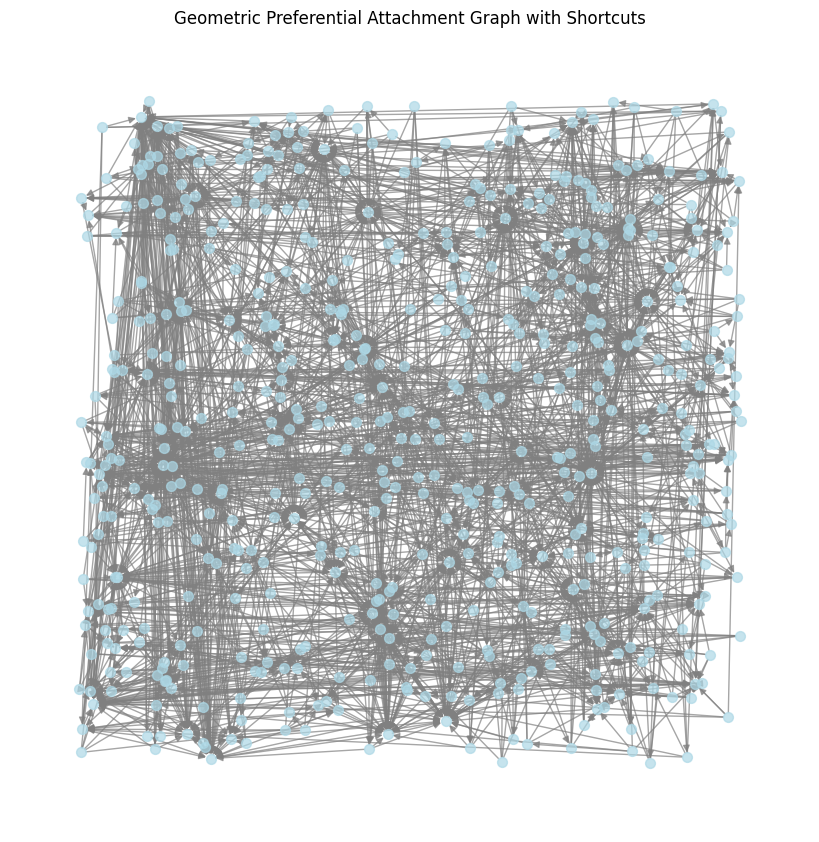

In [10]:
# Visualize the graph
plt.figure(figsize=(8,8))
nx.draw(G, pos, with_labels=False, node_size=50, node_color='lightblue', edge_color='gray', alpha=0.7)
plt.title("Geometric Preferential Attachment Graph with Shortcuts")
plt.show()

Clustering Coefficient: 0.27007787917116266
Average Shortest Path Length: 3.0658385093167704
Mean Betweenness Centrality: 0.003605302808580751
Mean Eigenvector Centrality: 0.03113754958074258
Mean Closeness Centrality: 0.3283402391783944
Average Degree: 10.090434782608696
Max In-Degree: 67
Max Out-Degree: 7


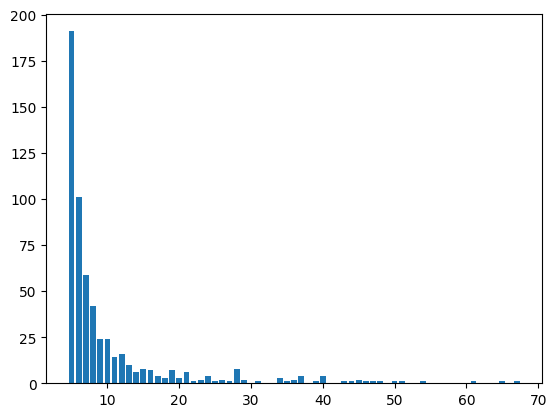

In [11]:
G_undir = G.to_undirected()

# Find clustering coefficient and average shortest path length
clustering_coeff = nx.average_clustering(G_undir)
avg_shortest_path_length = nx.average_shortest_path_length(G_undir)
print(f"Clustering Coefficient: {clustering_coeff}")
print(f"Average Shortest Path Length: {avg_shortest_path_length}")
# Betweenness, closeness, eigenvector centrality
betweenness = nx.betweenness_centrality(G_undir)
closeness = nx.closeness_centrality(G_undir)
eigenvector = nx.eigenvector_centrality(G_undir)
# Print mean of each centrality measure
print(f"Mean Betweenness Centrality: {np.mean(list(betweenness.values()))}")
print(f"Mean Eigenvector Centrality: {np.mean(list(eigenvector.values()))}")
print(f"Mean Closeness Centrality: {np.mean(list(closeness.values()))}")
# Average degree
avg_degree = sum(dict(G_undir.degree()).values()) / G_undir.number_of_nodes()
print(f"Average Degree: {avg_degree}")
# Max in/out degree
max_in_degree = max(dict(G.in_degree()).values())
max_out_degree = max(dict(G.out_degree()).values())
print(f"Max In-Degree: {max_in_degree}")
print(f"Max Out-Degree: {max_out_degree}")
# Degree distribution hist
degree_sequence = sorted([d for n, d in G_undir.degree()], reverse=True)
degree_count = Counter(degree_sequence)
deg, cnt = zip(*degree_count.items())
plt.bar(deg, cnt)
plt.show()

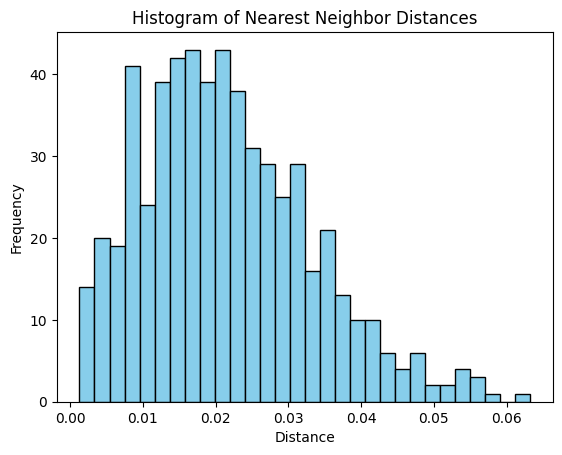

In [12]:
# Find distribution of geometric distances
positions = np.array([G.nodes[n]['pos'] for n in G.nodes()])
tree = cKDTree(positions)
distances, _ = tree.query(positions, k=2)  # k=2 to get the nearest neighbor (excluding self)
nearest_distances = distances[:, 1]  # Exclude self-distance at index 0
# Plot histogram of nearest neighbor distances
plt.hist(nearest_distances, bins=30, color='skyblue', edgecolor='black')
plt.title("Histogram of Nearest Neighbor Distances")
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.show()

## Generative model 2

In [13]:
# --------------------------
# Topology terms T_ij (directed variants)
# --------------------------
def matching_out(G, i, j):
    """Directed matching (Jaccard) on OUT-neighborhoods, excluding i->j."""
    Ni = set(G.successors(i)) - {j}
    Nj = set(G.successors(j)) - {i}
    if not Ni and not Nj: return 0.0
    return len(Ni & Nj) / len(Ni | Nj)

def neighbors_out(G, i, j):
    """# of common OUT-neighbors (directed analog of 'Neighbors')."""
    return len(set(G.successors(i)) & set(G.successors(j)))

def deg_avg(G, i, j):
    return 0.5 * (G.degree(i) + G.degree(j))

def deg_prod(G, i, j):
    return G.degree(i) * G.degree(j)

def clu_coeff(G, n):
    """Local clustering for directed graphs: use nx.clustering on symmetrized view."""
    # undirected projection for a simple directed analog
    if "_und" not in G.graph:
        G.graph["_und"] = G.to_undirected()
    return nx.clustering(G.graph["_und"], n)

def clu_avg(G, i, j):
    return 0.5 * (clu_coeff(G, i) + clu_coeff(G, j))

TOPO_FUNCS = {
    "matching_out": matching_out,  # homophily (recommended)
    "neighbors_out": neighbors_out, # homophily (# common neighbors)
    "deg_avg": deg_avg,             # degree-based
    "deg_prod": deg_prod,           # degree-based
    "clu_avg": clu_avg,             # clustering-based (simple directed analog)
}

# --------------------------
# Core: compute θ_ij (additive cost + topology), normalized parts
# --------------------------
def compute_theta_additive(G, D, eta, alpha, gamma, topo_name, candidates):
    """
    D: (N,N) distance matrix for current time step (static or growth slice)
    candidates: list of (i,j) directed pairs not yet connected (and i!=j)
    """
    topo = TOPO_FUNCS[topo_name]
    N = G.number_of_nodes()

    # cost term: exp(-eta*D_ij), normalized by its max over candidates
    Dij = np.array([D[i, j] for (i, j) in candidates], dtype=float)
    cost = np.exp(-eta * Dij)
    cmax = cost.max() if cost.size else 1.0
    cost_norm = cost / (cmax + 1e-12)

    # topology term: (T_ij^gamma), normalized by its max over candidates
    Tij = np.array([max(0.0, float(topo(G, i, j))) for (i, j) in candidates], dtype=float)
    # small epsilon to avoid all-zero; we treat negatives as 0.0 for these topology choices
    Tij_pow = np.power(Tij + 1e-12, gamma)
    tmax = Tij_pow.max() if Tij_pow.size else 1.0
    topo_norm = Tij_pow / (tmax + 1e-12)

    theta = cost_norm + alpha * topo_norm
    # avoid degenerate all-zero
    if theta.sum() <= 0:
        theta = np.ones_like(theta)
    return theta

# --------------------------
# Generator (static distances)
# --------------------------
def generate_static_additive(
    positions,         # (N,d) array OR None (then you must pass D)
    E,                 # number of directed edges to add
    eta=0.3, alpha=4.0, gamma=1.5,
    topo_name="matching_out",
    D=None,            # (N,N) distances; if None, compute Euclidean from positions
    forbid_self_loops=True,
    seed=0
):
    rng = np.random.default_rng(seed)
    N = (positions.shape[0] if positions is not None else D.shape[0])
    if D is None:
        # Euclidean distances (or replace with your fiber/geodesic distances)
        D = np.linalg.norm(
            positions[:, None, :] - positions[None, :, :], axis=-1
        )

    G = nx.DiGraph()
    G.add_nodes_from(range(N))
    if positions is not None:
        for i in range(N):
            G.nodes[i]["pos"] = positions[i]

    # iterative, one edge at a time
    for _ in range(E):
        # candidate pairs (i,j) where edge not yet present
        if forbid_self_loops:
            candidates = [(i, j) for i in range(N) for j in range(N) if i != j and not G.has_edge(i, j)]
        else:
            candidates = [(i, j) for i in range(N) for j in range(N) if not G.has_edge(i, j)]
        if not candidates:
            break

        theta = compute_theta_additive(G, D, eta, alpha, gamma, topo_name, candidates)
        probs = theta / theta.sum()
        idx = rng.choice(len(candidates), p=probs)
        u, v = candidates[idx]
        G.add_edge(u, v)

    return G

# --------------------------
# Generator (growth variant with time-varying distances)
# --------------------------
def generate_growth_additive(
    D_slices,          # list/array of K distance matrices, each (N,N) for time t
    E,                 # total number of edges to add across all slices
    eta=0.35, alpha=5.0, gamma=1.75,
    topo_name="matching_out",
    forbid_self_loops=True,
    seed=0
):
    """
    Adds ~E/K edges per time slice, updating topology as the graph grows.
    """
    rng = np.random.default_rng(seed)
    N = D_slices[0].shape[0]
    K = len(D_slices)

    G = nx.DiGraph()
    G.add_nodes_from(range(N))

    # distribute edges uniformly over slices (mirror Oldham's simple schedule)
    # (you can customize a nonuniform growth schedule)
    per = [E // K] * K
    for r in range(E % K):
        per[r] += 1

    for t, n_add in enumerate(per):
        if n_add <= 0:
            continue
        D = D_slices[t]
        for _ in range(n_add):
            if forbid_self_loops:
                candidates = [(i, j) for i in range(N) for j in range(N) if i != j and not G.has_edge(i, j)]
            else:
                candidates = [(i, j) for i in range(N) for j in range(N) if not G.has_edge(i, j)]
            if not candidates:
                break
            theta = compute_theta_additive(G, D, eta, alpha, gamma, topo_name, candidates)
            probs = theta / theta.sum()
            idx = rng.choice(len(candidates), p=probs)
            u, v = candidates[idx]
            G.add_edge(u, v)

    return G

In [14]:
# ---- Static distances (e.g., Euclidean from 2D positions) ----
N = 200
pos = np.random.RandomState(0).rand(N, 2)
G_static = generate_static_additive(
    positions=pos,
    E=2000,                 # target # of directed edges (~5% density here)
    eta=0.3, alpha=4.0, gamma=1.5,
    topo_name="matching_out",
    forbid_self_loops=True,
    seed=42
)

# ---- Growth (time-varying distances) ----
# Suppose you have K distance snapshots D_slices[t] shaped (N,N)
# (If you only have adult Euclidean, you can fabricate a simple "shrinking brain"
# by multiplying distances each earlier step by a factor <1.)
# K = 10
# D_adult = np.linalg.norm(pos[:,None,:] - pos[None,:,:], axis=-1)
# D_slices = [ (0.6 + 0.04*t) * D_adult for t in range(K) ]  # toy shrink/grow schedule

# G_growth = generate_growth_additive(
#     D_slices=D_slices,
#     E=2000,
#     eta=0.35, alpha=5.0, gamma=1.75,
#     topo_name="matching_out",
#     forbid_self_loops=True,
#     seed=7
# )

In [28]:
G = G_static

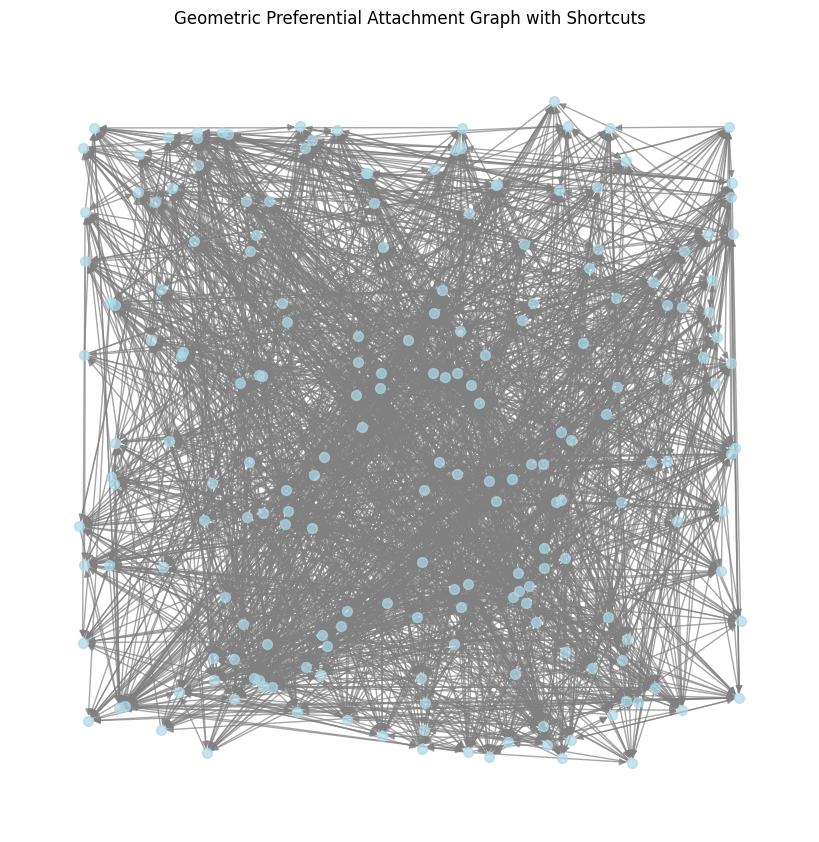

In [29]:
# Visualize the graph
plt.figure(figsize=(8,8))
nx.draw(G, pos, with_labels=False, node_size=50, node_color='lightblue', edge_color='gray', alpha=0.7)
plt.title("Geometric Preferential Attachment Graph with Shortcuts")
plt.show()

Clustering Coefficient: 0.10774257985245564
Average Shortest Path Length: 2.0369346733668343
Mean Betweenness Centrality: 0.005237043804883002
Mean Eigenvector Centrality: 0.06881802593837671
Mean Closeness Centrality: 0.49180674651605094
Average Degree: 19.47
Max In-Degree: 20
Max Out-Degree: 19


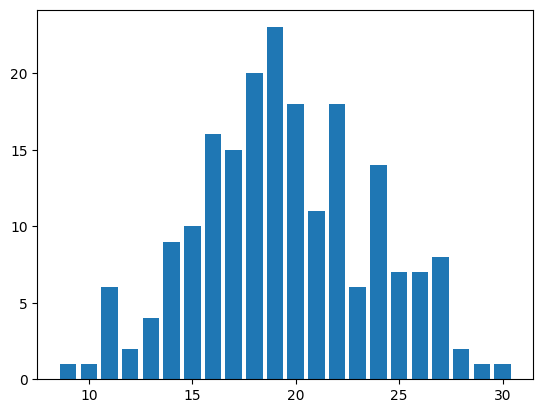

In [30]:
G_undir = G.to_undirected()

# Find clustering coefficient and average shortest path length
clustering_coeff = nx.average_clustering(G_undir)
avg_shortest_path_length = nx.average_shortest_path_length(G_undir)
print(f"Clustering Coefficient: {clustering_coeff}")
print(f"Average Shortest Path Length: {avg_shortest_path_length}")
# Betweenness, closeness, eigenvector centrality
betweenness = nx.betweenness_centrality(G_undir)
closeness = nx.closeness_centrality(G_undir)
eigenvector = nx.eigenvector_centrality(G_undir)
# Print mean of each centrality measure
print(f"Mean Betweenness Centrality: {np.mean(list(betweenness.values()))}")
print(f"Mean Eigenvector Centrality: {np.mean(list(eigenvector.values()))}")
print(f"Mean Closeness Centrality: {np.mean(list(closeness.values()))}")
# Average degree
avg_degree = sum(dict(G_undir.degree()).values()) / G_undir.number_of_nodes()
print(f"Average Degree: {avg_degree}")
# Max in/out degree
max_in_degree = max(dict(G.in_degree()).values())
max_out_degree = max(dict(G.out_degree()).values())
print(f"Max In-Degree: {max_in_degree}")
print(f"Max Out-Degree: {max_out_degree}")
# Degree distribution hist
degree_sequence = sorted([d for n, d in G_undir.degree()], reverse=True)
degree_count = Counter(degree_sequence)
deg, cnt = zip(*degree_count.items())
plt.bar(deg, cnt)
plt.show()

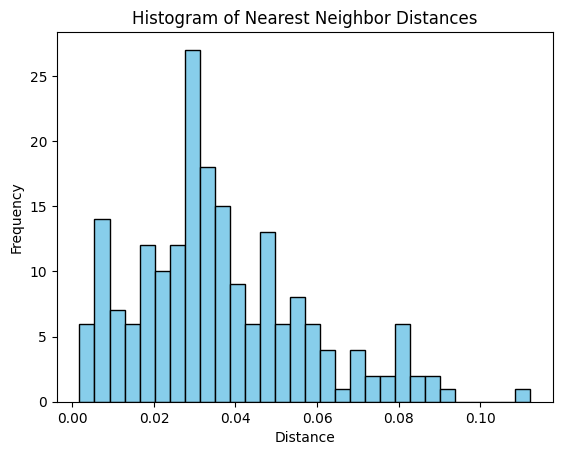

In [31]:
# Find distribution of geometric distances
positions = np.array([G.nodes[n]['pos'] for n in G.nodes()])
tree = cKDTree(positions)
distances, _ = tree.query(positions, k=2)  # k=2 to get the nearest neighbor (excluding self)
nearest_distances = distances[:, 1]  # Exclude self-distance at index 0
# Plot histogram of nearest neighbor distances
plt.hist(nearest_distances, bins=30, color='skyblue', edgecolor='black')
plt.title("Histogram of Nearest Neighbor Distances")
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.show()

## Add attributes

In [33]:
# Add distance attribute to edges
for u, v in G.edges():
    d = np.linalg.norm(np.minimum(np.abs(pos[u] - pos[v]), 1.0 - np.abs(pos[u] - pos[v])) if True
                       else (pos[u] - pos[v]))
    G.edges[u, v]['distance'] = d

# Set all edges to dendritic false
for u, v in G.edges():
    G.edges[u, v]['dendritic'] = False

# Set all nodes to layer 0
for n in G.nodes():
    G.nodes[n]['layer'] = 0

In [169]:
# ---------------------------
# 0) Utilities
# ---------------------------
def _safe_ratio(a, b, eps=1e-9):
    return float(a) / float(b + eps)

def _rank01(arr):
    order = np.argsort(arr)
    ranks = np.empty_like(order, dtype=float)
    ranks[order] = np.linspace(0, 1, len(arr), endpoint=True)
    return ranks

# ---------------------------
# 1) Feature extraction
# ---------------------------
def compute_node_features(G: nx.DiGraph):
    """
    Returns:
      feats: dict[node] -> dict of features
      nodes: np.array of node ids (int or whatever G uses)
    Features include:
      k_in, k_out, k_tot, kout_kin, kin_kout, kout_frac, kin_frac,
      ranks in [0,1] for k_in, k_out, k_tot
      logs: log_k_in, log_k_out, log_k_tot (log1p)
    """
    nodes = np.array(list(G.nodes()))
    k_in = np.array([G.in_degree(n) for n in nodes], dtype=float)
    k_out = np.array([G.out_degree(n) for n in nodes], dtype=float)
    k_tot = k_in + k_out

    kout_kin = np.array([_safe_ratio(ko, ki) for ko, ki in zip(k_out, k_in)], dtype=float)
    kin_kout = 1.0 / (kout_kin + 1e-12)
    kout_frac = np.array([_safe_ratio(ko, kt) for ko, kt in zip(k_out, k_tot)], dtype=float)
    kin_frac  = 1.0 - kout_frac

    # ranks and logs
    r_in  = _rank01(k_in)
    r_out = _rank01(k_out)
    r_tot = _rank01(k_tot)
    log_k_in  = np.log1p(k_in)
    log_k_out = np.log1p(k_out)
    log_k_tot = np.log1p(k_tot)

    feats = {}
    for i, n in enumerate(nodes):
        feats[n] = {
            "k_in": k_in[i], "k_out": k_out[i], "k_tot": k_tot[i],
            "kout_kin": kout_kin[i], "kin_kout": kin_kout[i],
            "kout_frac": kout_frac[i], "kin_frac": kin_frac[i],
            "r_in": r_in[i], "r_out": r_out[i], "r_tot": r_tot[i],
            "log_k_in": log_k_in[i], "log_k_out": log_k_out[i], "log_k_tot": log_k_tot[i],
        }
    return feats, nodes

# ---------------------------
# 2) Assign E vs I with a target fraction
# ---------------------------
def assign_EI(G: nx.DiGraph, feats: dict, frac_E: float = 0.8, w = np.array([ 0.8, 0.9, 0.4 ]), seed: int = 0):
    """
    Uses a logistic score from features to prefer E for high total degree and high out/in ratio.
    Tune weights in 'w' as desired.
    """
    rng = np.random.default_rng(seed)
    nodes = list(G.nodes())
    X = np.array([[feats[n]["log_k_tot"], np.log(feats[n]["kout_kin"] + 1e-9), feats[n]["r_out"]] for n in nodes])
    # weights for features -> adjust if you like
          # total degree, kout/kin, out-rank
    b = -0.2                              # bias
    z = X @ w + b
    pE = 1.0 / (1.0 + np.exp(-z))         # logistic
    # enforce target fraction: pick top frac_E by pE
    idx_sorted = np.argsort(-pE)
    nE = int(round(frac_E * len(nodes)))
    E_idx = set(idx_sorted[:nE])
    E = {nodes[i] for i in E_idx}
    I = set(nodes) - E
    nx.set_node_attributes(G, {n: ('E' if n in E else 'I') for n in nodes}, "type")
    return E, I, pE

# ---------------------------
# 3) Split E into {'p23','TC'} and I into {'TI','TRN','nb1','b','nb'}
# ---------------------------
def split_excitatory(G, E: set, feats: dict,
                     tc_top_out_rank: float = 0.85,
                     tc_min_ratio: float = 1.2):
    """
    Heuristic:
      - 'TC' (relay-like) := very high out-degree rank and kout/kin > tc_min_ratio
      - others → 'p23'
    """
    labels = {}
    for n in E:
        r_out = feats[n]["r_out"]
        ratio = feats[n]["kout_kin"]
        if (r_out >= tc_top_out_rank) and (ratio >= tc_min_ratio):
            labels[n] = "TC"
        else:
            labels[n] = "ss4"
    return labels

def split_inhibitory(G, I: set, feats: dict,
                     trn_top_out_rank: float = 0.80,
                     trn_min_ratio: float = 1.05,
                     ti_high_in_rank: float = 0.75,
                     nb1_low_tot_rank: float = 0.20,
                     b_mid_tot_low: float = 0.20,
                     b_mid_tot_high: float = 0.70):
    """
    Heuristic partition (editable):
      - 'TRN' := top out-degree rank & kout/kin > trn_min_ratio (broad inhibitory projectors)
      - 'TI'  := high in-degree rank & kout/kin < 1 (local interneuron receiving a lot)
      - 'nb1' := very low total-degree rank (sparse local cells)
      - 'b'   := mid total-degree rank band
      - 'nb'  := remaining
    The exact biological mapping of 'nb1','b','nb' is user-defined—these are feature bins.
    """
    labels = {}
    # First pass: mark TRN and TI by strong cues
    for n in I:
        r_out = feats[n]["r_out"]; r_in = feats[n]["r_in"]; r_tot = feats[n]["r_tot"]
        ratio = feats[n]["kout_kin"]
        if (r_out >= trn_top_out_rank) and (ratio >= trn_min_ratio):
            labels[n] = "TRN"
        elif (r_in >= ti_high_in_rank) and (ratio < 1.0):
            labels[n] = "TI"
        else:
            labels[n] = None  # assign later

    # Second pass: among unlabeled, use total-degree bands for nb1/b/nb
    for n in I:
        if labels[n] is not None:
            continue
        r_tot = feats[n]["r_tot"]
        if r_tot <= nb1_low_tot_rank:
            labels[n] = "nb1"
        elif b_mid_tot_low < r_tot <= b_mid_tot_high:
            labels[n] = "b"
        else:
            labels[n] = "nb"
    return labels

def assign_named_classes(G: nx.DiGraph, E: set, I: set, feats: dict,
                         params_excit=None, params_inhib=None):
    exc = split_excitatory(G, E, feats, **(params_excit or {}))
    inh = split_inhibitory(G, I, feats, **(params_inhib or {}))
    cls = {**exc, **inh}
    nx.set_node_attributes(G, cls, "class")   # 'class' ∈ {p23,TC,TI,TRN,nb1,b,nb}
    return cls

# ---------------------------
# 4) Dale’s law weights + g tuning
# ---------------------------
def assign_dales_law_weights(G: nx.DiGraph, wE_mu=0.02, wE_sigma=0.8,
                             wI_mu=0.02, wI_sigma=0.8,
                             inhib_strength_factor=5.0,
                             degree_compensation=True,
                             target_out_sum_E=1.0, target_out_sum_I=1.0,
                             seed=1):
    rng = np.random.default_rng(seed)
    for u, v in G.edges():
        if G.nodes[u]["type"] == "E":
            mag = np.exp(rng.normal(np.log(wE_mu), wE_sigma))
            w = float(mag)
        else:
            mag = np.exp(rng.normal(np.log(wI_mu), wI_sigma))
            w = float(-inhib_strength_factor * mag)
        G[u][v]["w"] = w

    if degree_compensation:
        for u in G.nodes():
            succ = list(G.successors(u))
            if not succ: continue
            s = sum(abs(G[u][v]["w"]) for v in succ)
            if s <= 0: continue
            tgt = target_out_sum_E if G.nodes[u]["type"] == "E" else target_out_sum_I
            scale = tgt / s
            for v in succ:
                G[u][v]["w"] *= scale

def compute_g(G: nx.DiGraph, tau_E=1.0, tau_I=1.0):
    wE_in, wI_in, KE, KI = [], [], [], []
    for v in G.nodes():
        wE = [G[u][v]["w"] for u in G.predecessors(v) if G.nodes[u]["type"]=="E" and G[u][v]["w"]>0]
        wI = [G[u][v]["w"] for u in G.predecessors(v) if G.nodes[u]["type"]=="I" and G[u][v]["w"]<0]
        if wE: wE_in.append(np.mean(wE)); KE.append(len(wE))
        else:  KE.append(0)
        if wI: wI_in.append(np.mean(np.abs(wI))); KI.append(len(wI))
        else:  KI.append(0)
    if not wE_in or not wI_in: return np.nan, np.nan
    g_syn = float(np.median(wI_in) / np.median(wE_in))
    g_eff = float((np.mean(KI) * np.mean(wI_in) * tau_I) / (np.mean(KE) * np.mean(wE_in) * tau_E)) if np.mean(KE)*np.mean(wE_in) > 0 else np.nan
    return g_syn, g_eff

def rescale_inhibition_to_target_g(G: nx.DiGraph, target_g_eff=5.0, tau_E=1.0, tau_I=1.0):
    _, g_eff0 = compute_g(G, tau_E, tau_I)
    if not np.isfinite(g_eff0) or g_eff0==0: return 1.0, g_eff0, g_eff0
    scale = target_g_eff / g_eff0
    for u, v in G.edges():
        if G.nodes[u]["type"] == "I":
            G[u][v]["w"] *= scale
    g_syn1, g_eff1 = compute_g(G, tau_E, tau_I)
    return scale, g_eff0, g_eff1

# ---------------------------
# 5) Example end-to-end
# ---------------------------
def assign_all(G: nx.DiGraph,
               frac_E=0.8,
               seed=0,
               params_excit=None,
               params_inhib=None,
               w = np.array([ 0.8, 0.9, 0.4 ]),
               target_g_eff=5.0,
               inhib_strength_factor=5.0):
    """
    w: weights for features -> adjust if you like: total degree, kout/kin, out-rank
    """
    feats, nodes = compute_node_features(G)
    E, I, pE = assign_EI(G, feats, frac_E=frac_E, w = w, seed=seed)

    # Split into named classes based on features
    classes = assign_named_classes(G, E, I, feats, params_excit=params_excit, params_inhib=params_inhib)

    # Dale’s law weights and inhibitory gain
    assign_dales_law_weights(G, inhib_strength_factor=inhib_strength_factor, degree_compensation=True, seed=seed)
    # scale, g0, g1 = rescale_inhibition_to_target_g(G, target_g_eff=target_g_eff)

    return {
        "E_count": len(E), "I_count": len(I),
        "class_counts": {c: sum(1 for n in classes if classes[n]==c) for c in ["ss4","TC","TI","TRN","nb1","b","nb"]},
        # "g_eff_before": g0, "g_eff_after": g1, "I_scale": scale
    }


In [170]:
# params_inhib = {
#     "trn_top_out_rank": 0.1,
#     "trn_min_ratio": 1.05,
#     "ti_high_in_rank": 0.9,
#     "nb1_low_tot_rank": 0.75,
#     "b_mid_tot_low": 0.50,
#     "b_mid_tot_high": 0.85
# }

params_inhib = {
    "trn_top_out_rank": 0.01,
    "trn_min_ratio": 1.05,
    "ti_high_in_rank": 0.75,
    "nb1_low_tot_rank": 0.1,
    "b_mid_tot_low": 0.20,
    "b_mid_tot_high": 0.70
}

# def split_inhibitory(G, I: set, feats: dict,
#                      trn_top_out_rank: float = 0.80,
#                      trn_min_ratio: float = 1.05,
#                      ti_high_in_rank: float = 0.75,
#                      nb1_low_tot_rank: float = 0.20,
#                      b_mid_tot_low: float = 0.20,
#                      b_mid_tot_high: float = 0.70):

# params_inhib = None

summary = assign_all(G, frac_E=0.8, target_g_eff=1.0, params_inhib=params_inhib, w = np.array([ 2, 1, 2 ]), inhib_strength_factor=1.0)
print(summary)

{'E_count': 160, 'I_count': 40, 'class_counts': {'ss4': 138, 'TC': 22, 'TI': 9, 'TRN': 3, 'nb1': 11, 'b': 9, 'nb': 8}}


In [167]:
# Spectral radius of weight matrix
def compute_spectral_radius(G: nx.DiGraph, weight_str='w'):
    N = G.number_of_nodes()
    if N > 500:
        print("Warning: spectral radius computation may be slow for large graphs.")
    W = np.zeros((N, N), dtype=float)
    node_list = list(G.nodes())
    node_index = {n: i for i, n in enumerate(node_list)}
    for u, v in G.edges():
        i, j = node_index[u], node_index[v]
        W[i, j] = G[u][v][weight_str]
    eigs = np.linalg.eigvals(W)
    rho = max(abs(eigs))
    return rho

rho = compute_spectral_radius(G)
print(f"Spectral Radius of Weight Matrix: {rho}")

Spectral Radius of Weight Matrix: 0.8759022543484495


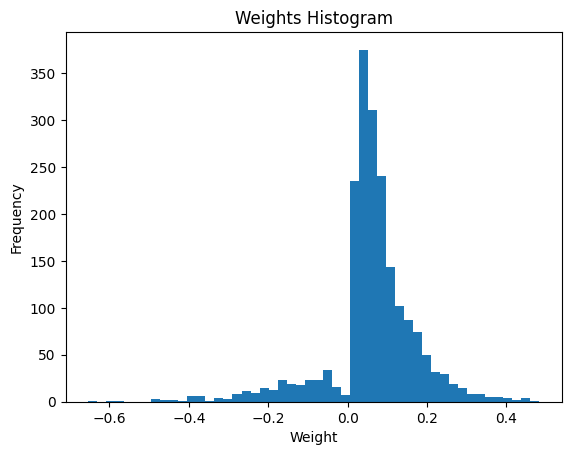

In [171]:
# Show weights histogram
weights = [G[u][v]['w'] for u, v in G.edges()]
plt.hist(weights, bins=50)
plt.xlabel("Weight")
plt.ylabel("Frequency")
plt.title("Weights Histogram")
plt.show()

In [172]:
# Print node and edge properties
for n in list(G.nodes(data=True))[:5]:
    print(n)
for u, v, d in list(G.edges(data=True))[:5]:
    print(u, v, d)

(0, {'pos': array([0.5488135 , 0.71518937]), 'layer': 0, 'inhibitory': False, 'ntype': 'ss4', 'type': 'E', 'class': 'ss4'})
(1, {'pos': array([0.60276338, 0.54488318]), 'layer': 0, 'inhibitory': True, 'ntype': 'TI', 'type': 'I', 'class': 'TI'})
(2, {'pos': array([0.4236548 , 0.64589411]), 'layer': 0, 'inhibitory': False, 'ntype': 'ss4', 'type': 'E', 'class': 'ss4'})
(3, {'pos': array([0.43758721, 0.891773  ]), 'layer': 0, 'inhibitory': False, 'ntype': 'ss4', 'type': 'E', 'class': 'ss4'})
(4, {'pos': array([0.96366276, 0.38344152]), 'layer': 0, 'inhibitory': False, 'ntype': 'ss4', 'type': 'E', 'class': 'ss4'})
0 175 {'distance': np.float64(0.3344737077797165), 'dendritic': False, 'weight': 0.08338866470985527, 'w': 0.08338866470985527}
0 62 {'distance': np.float64(0.16568409190821545), 'dendritic': False, 'weight': 0.06784626371118245, 'w': 0.06784626371118245}
0 47 {'distance': np.float64(0.5350869768453257), 'dendritic': False, 'weight': 0.12587210211628708, 'w': 0.12587210211628708}


In [173]:
# Rename "w" to "weight" for NeuroSimV3 compatibility
for u, v in G.edges():
    G[u][v]['weight'] = G[u][v].pop('w')

# Define boolean inhibitory node property
nx.set_node_attributes(G, {n: (G.nodes[n]["type"] == "I") for n in G.nodes()}, "inhibitory")
# Remove "type" attribute to avoid confusion with inhibitory boolean
for n in G.nodes():
    G.nodes[n].pop("type", None)

# Rename class to ntype for NeuroSimV3 compatibility
nx.set_node_attributes(G, {n: G.nodes[n].pop("class") for n in G.nodes()}, "ntype")

In [174]:
# Make weights positive for all edges
for u, v in G.edges():
    G[u][v]['weight'] = abs(G[u][v]['weight'])

In [175]:
# Print node and edge properties
for n in list(G.nodes(data=True))[:5]:
    print(n)
for u, v, d in list(G.edges(data=True))[:5]:
    print(u, v, d)

(0, {'pos': array([0.5488135 , 0.71518937]), 'layer': 0, 'inhibitory': False, 'ntype': 'ss4'})
(1, {'pos': array([0.60276338, 0.54488318]), 'layer': 0, 'inhibitory': True, 'ntype': 'TI'})
(2, {'pos': array([0.4236548 , 0.64589411]), 'layer': 0, 'inhibitory': False, 'ntype': 'ss4'})
(3, {'pos': array([0.43758721, 0.891773  ]), 'layer': 0, 'inhibitory': False, 'ntype': 'ss4'})
(4, {'pos': array([0.96366276, 0.38344152]), 'layer': 0, 'inhibitory': False, 'ntype': 'ss4'})
0 175 {'distance': np.float64(0.3344737077797165), 'dendritic': False, 'weight': 0.08338866470985527}
0 62 {'distance': np.float64(0.16568409190821545), 'dendritic': False, 'weight': 0.06784626371118245}
0 47 {'distance': np.float64(0.5350869768453257), 'dendritic': False, 'weight': 0.12587210211628708}
0 184 {'distance': np.float64(0.35612108727190595), 'dendritic': False, 'weight': 0.08201058318969238}
0 156 {'distance': np.float64(0.6003499253176118), 'dendritic': False, 'weight': 0.049126210444325503}


In [176]:
rho = compute_spectral_radius(G, weight_str='weight')
print(f"Spectral Radius of Weight Matrix: {rho}")

Spectral Radius of Weight Matrix: 1.0000000000000024


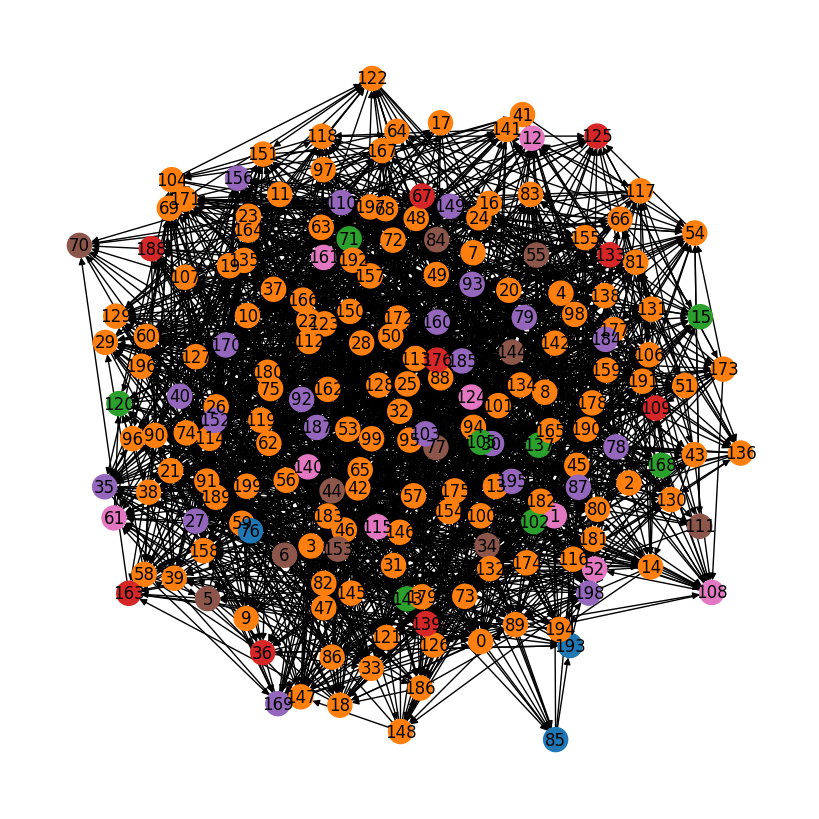

In [177]:
# Plot graph colored by ntype
ntypes = list(set(nx.get_node_attributes(G, "ntype").values()))
color_map = plt.get_cmap('tab10')
ntype_to_color = {ntype: color_map(i % 10) for i, ntype in enumerate(ntypes)}
node_colors = [ntype_to_color[G.nodes[n]['ntype']] for n in G.nodes()]
plt.figure(figsize=(8,8))
nx.draw(G, node_color=node_colors, with_labels=True)

## Simulation

In [178]:
dt = 0.1

In [179]:
# Neuron population parameters
n_neurons = G.number_of_nodes()
neuron_types = ["ss4", "TC", "TI", "TRN", "nb1", "b", "nb"]
n_neuron_types = len(neuron_types)
inhibitory = [False, False, True, True, True, True, True]
threshold_decay = np.exp(-dt / 5)

pop = NeuronPopulation(n_neurons, neuron_types, inhibitory, threshold_decay)

In [180]:
# Connectome
# Max number of outgoing synapses per neuron
max_synapses = max(dict(G.out_degree()).values())

connectome = Connectome(max_synapses, pop)

connectome.nx_to_connectome(G)

In [189]:
sim = Simulation(connectome, dt, stepper_type="adapt")

I_ext = np.zeros((pop.n_neurons))
I_ext[pop.get_neurons_from_type("TC")] = 150
I_ext[pop.get_neurons_from_type("TI")] = 0

# I_ext = 100

for i in range(2000):
    sim.step(I_ext=I_ext)

weights_t1 = connectome.W.copy()


I_ext[pop.get_neurons_from_type("TC")] = 0
I_ext[pop.get_neurons_from_type("TI")] = 0



for i in range(3000):
    sim.step(I_ext=I_ext)

weights_t1 = connectome.W.copy()

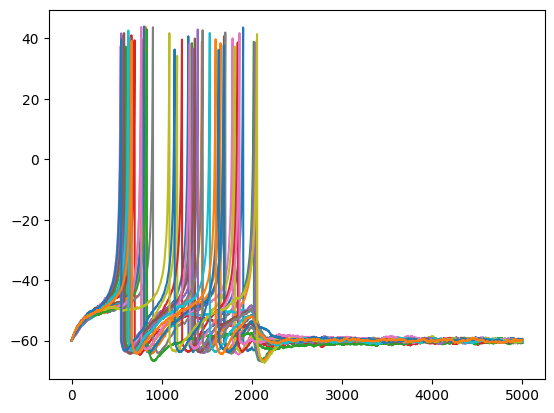

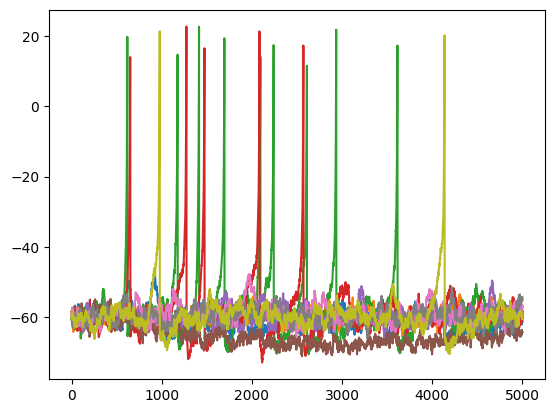

In [190]:
plt.plot(np.array(sim.stats.Vs)[:, pop.get_neurons_from_type("TC")])
plt.show()
plt.plot(np.array(sim.stats.Vs)[:, pop.get_neurons_from_type("TI")])
plt.show()

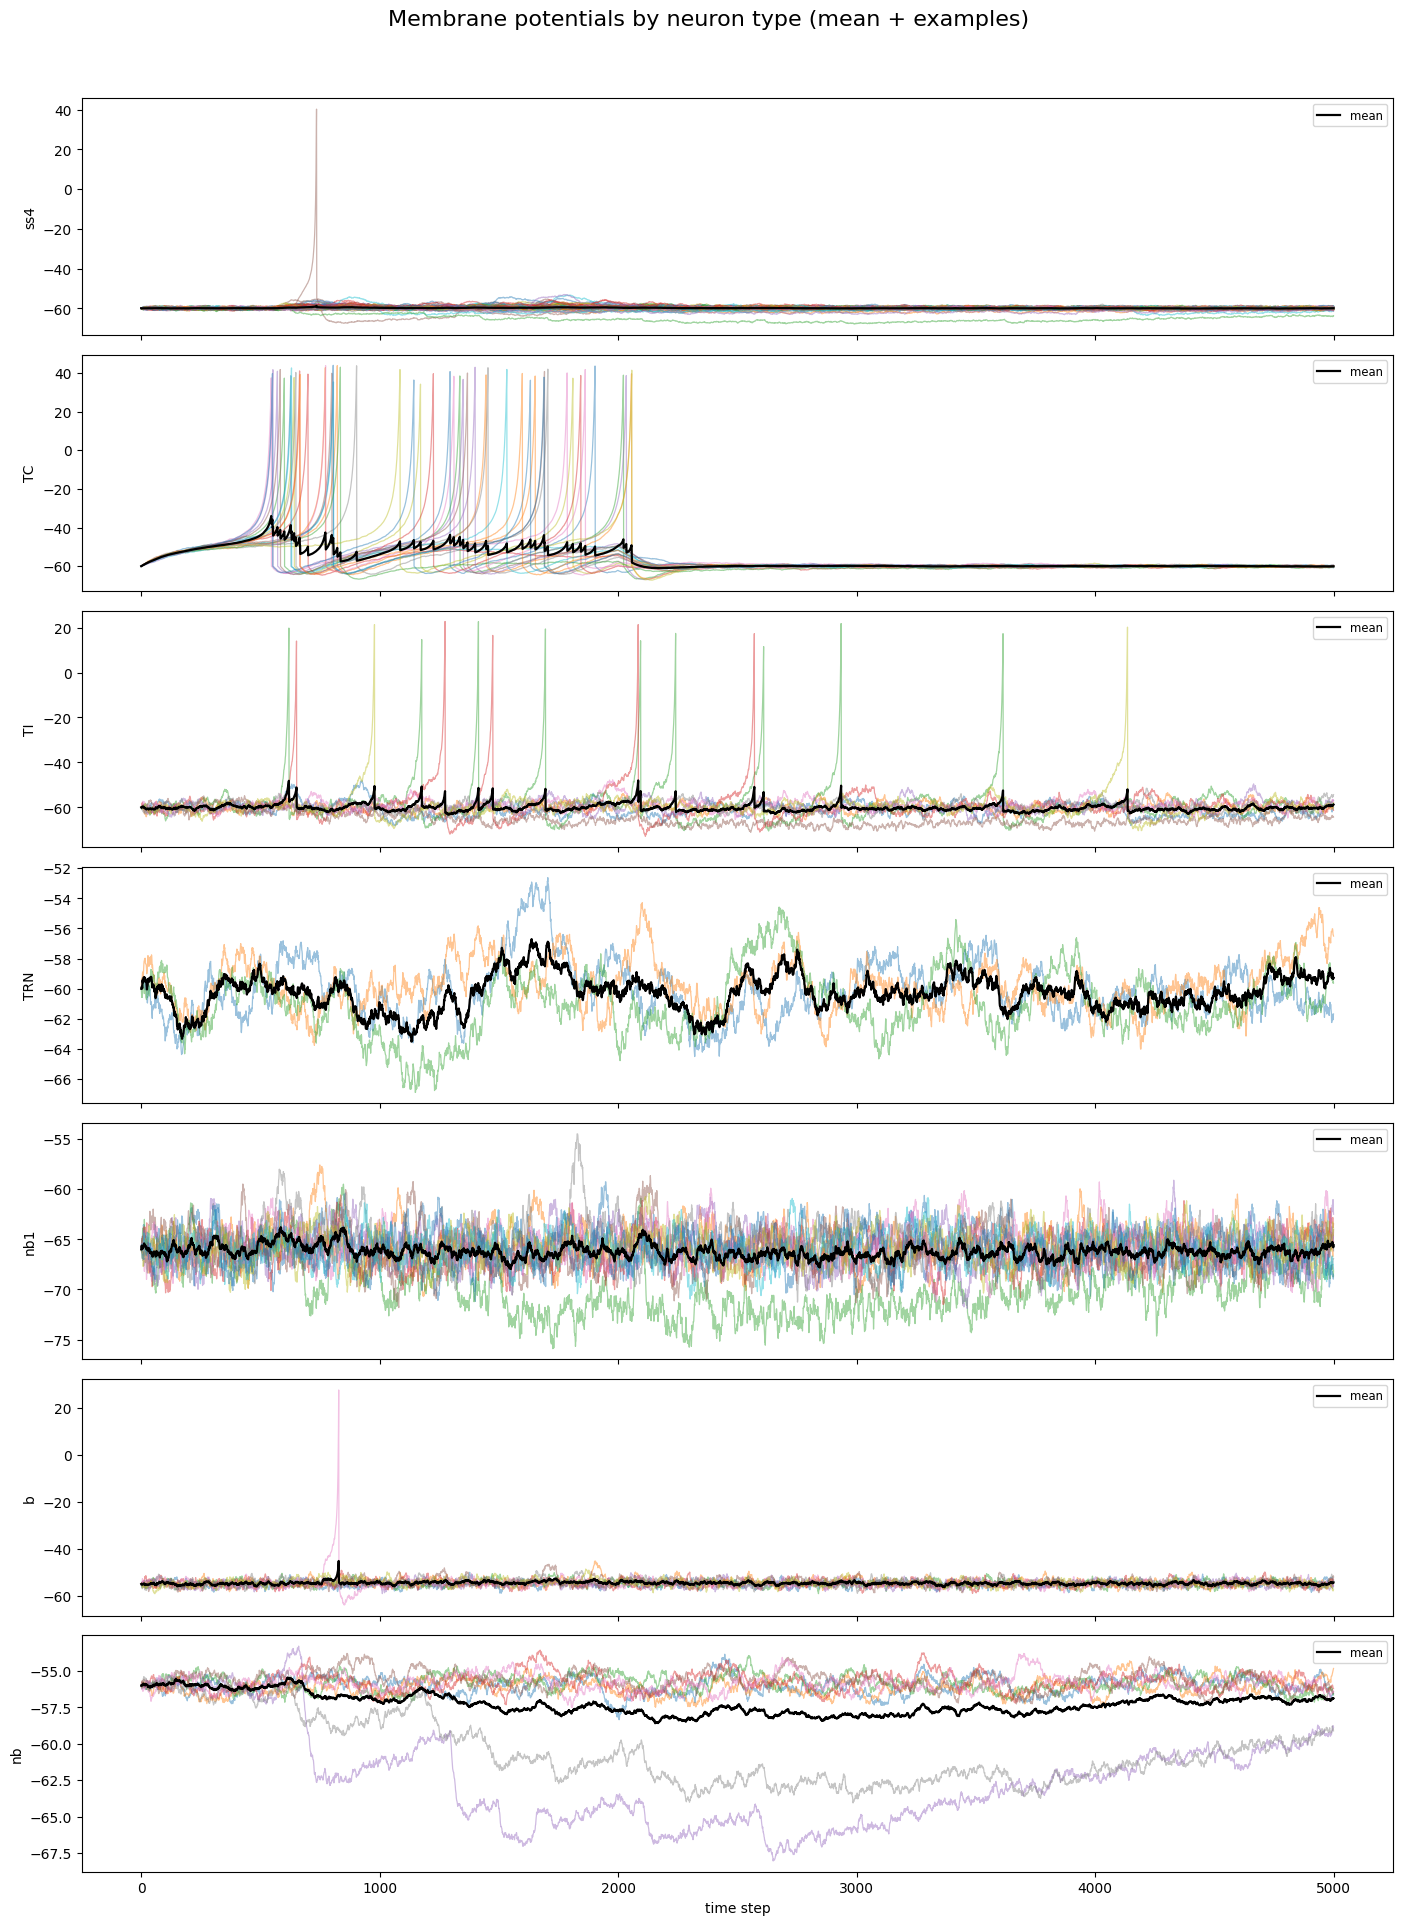

In [191]:
# Make a single big figure with one subplot per neuron type
# neuron_types = ["p23", "TC", "TI", "TRN", "nb1", "b", "nb"]
# Convert recorded voltages to an array: shape (time_steps, n_neurons)
Vs = np.array(sim.stats.Vs)
n_types = len(neuron_types)
fig, axs = plt.subplots(n_types, 1, figsize=(14, 2.8 * n_types), sharex=True)
# If there's only one subplot, make axs iterable
if n_types == 1:
    axs = [axs]
for ax, ntype in zip(axs, neuron_types):
    idx = pop.get_neurons_from_type(ntype)
    if len(idx) == 0:
        ax.text(0.5, 0.5, f"No neurons of type {ntype}", ha='center', va='center')
        ax.set_ylabel(ntype)
        continue
    data = Vs[:, idx]  # time x neurons_of_type
    # Plot up to 6 individual neuron traces (lighter) and the mean (darker)
    n_show = min(500, data.shape[1])
    for j in range(n_show):
        ax.plot(data[:, j], alpha=0.45, linewidth=0.9)
    ax.plot(data.mean(axis=1), color='k', linewidth=1.6, label='mean')
    ax.set_ylabel(ntype)
    ax.legend(loc='upper right', fontsize='small')
axs[-1].set_xlabel('time step')
fig.suptitle('Membrane potentials by neuron type (mean + examples)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Metrics

In [ ]:
from scipy.signal import welch
from itertools import combinations

def spike_counts(spikes, T_ms, bin_ms):
    edges = np.arange(0, T_ms + 1e-6, bin_ms)
    counts = np.stack([np.histogram(s, bins=edges)[0] for s in spikes], axis=0)
    return counts, edges

def firing_rates(spikes, T_ms):
    return np.array([len(s) / (T_ms/1000.0) for s in spikes])  # Hz

def isi_cv(spikes):
    cvs = []
    for s in spikes:
        if len(s) < 3: 
            cvs.append(np.nan); continue
        isi = np.diff(s)
        m = isi.mean()
        cvs.append(isi.std()/m if m>0 else np.nan)
    return np.array(cvs)

def fano_factor(counts):
    # counts: (N, Tbins)
    mu = counts.mean(axis=1)
    var = counts.var(axis=1, ddof=1)
    with np.errstate(divide='ignore', invalid='ignore'):
        return np.where(mu>0, var/mu, np.nan)

def mean_noise_correlation(counts, detrend=True):
    X = counts.copy().astype(float)
    if detrend:
        X -= X.mean(axis=1, keepdims=True)
    # z-score per neuron
    std = X.std(axis=1, keepdims=True) + 1e-9
    X /= std
    C = (X @ X.T) / X.shape[1]
    # remove self
    N = C.shape[0]
    iu = np.triu_indices(N, k=1)
    return np.nanmean(C[iu]), C

def population_rate(spikes, T_ms, dt_ms=1.0, smooth_ms=10.0):
    # bin then Gaussian smooth
    counts, edges = spike_counts(spikes, T_ms, dt_ms)
    pr = counts.sum(axis=0) / (dt_ms/1000.0)  # spikes/s across population
    if smooth_ms > 0:
        k = int(6*smooth_ms/dt_ms)
        t = np.arange(-k, k+1)*dt_ms
        g = np.exp(-0.5*(t/smooth_ms)**2); g /= g.sum()
        pr = np.convolve(pr, g, mode='same')
    return pr, edges[:-1]

def power_spectrum(x, fs_hz):
    f, Pxx = welch(x, fs=fs_hz, nperseg=min(len(x), 2048))
    return f, Pxx

def spectral_entropy(Pxx):
    p = Pxx / (Pxx.sum() + 1e-12)
    return -np.sum(p * np.log(p + 1e-12))

def branching_ratio(spikes, bin_ms=2.0, horizon_bins=3):
    # simple cascade estimator from population counts
    counts, _ = spike_counts(spikes, T_ms=max(max(s, default=0) for s in spikes)+bin_ms, bin_ms=bin_ms)
    n = counts.sum(axis=0)
    m_est = []
    for t in range(len(n)-horizon_bins-1):
        parents = n[t]
        children = n[t+1:t+1+horizon_bins].sum()
        if parents > 0:
            m_est.append(children/parents)
    return np.nan if not m_est else float(np.mean(m_est))

def participation_ratio(X):
    # X: (N, Tbins) z-scored activity (e.g., spike counts or rates)
    X = X - X.mean(axis=1, keepdims=True)
    C = (X @ X.T) / X.shape[1]
    evals = np.linalg.eigvalsh(C)
    evals = np.maximum(evals, 0)
    s1 = evals.sum(); s2 = (evals**2).sum() + 1e-12
    return float((s1**2)/s2)

# ---- Run the QC battery (example choices) ----
T_ms = 5000.0
dt = 0.1  # ms

def bool_to_spike_times(spikes_bool, dt_ms=0.1):
    n, T = spikes_bool.shape
    spike_times = [np.where(spikes_bool[i])[0] * dt_ms for i in range(n)]
    return spike_times

spikes = bool_to_spike_times(np.array(sim.stats.spikes), dt_ms=0.1)

# 1) Single-neuron
rates = firing_rates(spikes, T_ms)
cvs   = isi_cv(spikes)
counts_50, _ = spike_counts(spikes, T_ms, bin_ms=50.0)
fanos = fano_factor(counts_50)

# 2) Pairwise & population
mn_corr, corr_mat = mean_noise_correlation(counts_50, detrend=True)
pop_rate, t_bins = population_rate(spikes, T_ms, dt_ms=1.0, smooth_ms=10.0)
fs = 1000.0  # Hz (1 ms bins)
f, Pxx = power_spectrum(pop_rate, fs_hz=1000.0)
sent = spectral_entropy(Pxx)

# 3) Branching & dimensionality
m_hat = branching_ratio(spikes, bin_ms=2.0, horizon_bins=3)
# PR on z-scored counts at 10 ms for smoother structure
counts_10, _ = spike_counts(spikes, T_ms, bin_ms=10.0)
X = (counts_10 - counts_10.mean(axis=1, keepdims=True)) / (counts_10.std(axis=1, keepdims=True)+1e-9)
pr_dim = participation_ratio(X)

summary = {
    "rate_mean_Hz": float(np.nanmean(rates)),
    "rate_median_Hz": float(np.nanmedian(rates)),
    "rate_p95_Hz": float(np.nanpercentile(rates,95)),
    "ISI_CV_median": float(np.nanmedian(cvs)),
    "Fano_median_50ms": float(np.nanmedian(fanos)),
    "mean_noise_corr_50ms": float(mn_corr),
    "pop_spec_entropy": float(sent),
    "branching_m_hat": float(m_hat),
    "participation_ratio": float(pr_dim),
}
print(summary)


{'rate_mean_Hz': 0.0026794641071785645, 'rate_median_Hz': 0.0, 'rate_p95_Hz': 0.0, 'ISI_CV_median': nan, 'Fano_median_50ms': 0.9999999999999998, 'mean_noise_corr_50ms': 0.0001768446275190734, 'pop_spec_entropy': 0.6387162064548405, 'branching_m_hat': 2.7233333333333336, 'participation_ratio': 1.9889154504745516}


C:\Users\kingt\AppData\Local\Temp\ipykernel_23884\398424872.py:117: RuntimeWarning: All-NaN slice encountered
  "ISI_CV_median": float(np.nanmedian(cvs)),
